In [2]:
from sympy import symbols, Function, Derivative, laplace_transform, symbols, Function, exp, Dummy
from sympy.abc import t, s
from IPython.display import display
from utils.int_transform import laplace_transform_extended as lt, lt_as_piecewise as ltpw
functions = lambda *args, **kwargs: symbols(*args, **kwargs, cls=Function)


In [3]:
f, F=functions('f F')
lt_fmap = {f: F}
df_dx=Derivative(f(t), t, 2)
lt(df_dx + t, t, s, fmap=lt_fmap, noconds=True)

s**2*F(s) + s**(-2)

In [4]:
from sympy import LaplaceTransform, Eq, sin
expr = 3*df_dx+sin(t)
result, roc, conds = lt(expr, t, s, fmap={f: F}, czero=False)
extended_pwf = ltpw((result, roc, conds), s)
pwf = ltpw(laplace_transform(expr, t, s), s)
display(Eq(LaplaceTransform(expr, t, s), extended_pwf))
display(Eq(LaplaceTransform(expr, t, s), pwf))



Eq(LaplaceTransform(sin(t) + 3*Derivative(f(t), (t, 2)), t, s), Piecewise((3*s**2*F(s) - 3*s*f(0) - 3*Subs(Derivative(f(t), t), t, 0) + 1/(s**2 + 1), re(s) > 0)))

Eq(LaplaceTransform(sin(t) + 3*Derivative(f(t), (t, 2)), t, s), Piecewise((3*LaplaceTransform(Derivative(f(t), (t, 2)), t, s) + 1/(s**2 + 1), re(s) > 0)))

## Punto 4
### a)
La respuesta escalón en el gráfico presenta un comportamiento de crecimiento exponencial asintótico y no contiene componentes oscilantes, por lo que podría considerarla propia de un sistema de primer orden. Sin embargo, la pendiente horizontal de la curva al momento de activación no corresponde a un sistema de primer orden, por lo que más probablemente el sistema sea sobreamortiguado de segundo orden.

### b)


zn: 		tau=0.064, kp=0.98, tita=0.000
hagglund: 	tau=0.058, kp=0.98, tita=0.000
sm: 		(tau1=0.040, tau2=0.015), kp=0.98, tita=-0.004


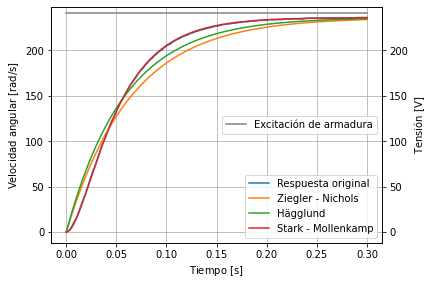

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt
from functools import partial
from utils.misc import find_roots as roots
from utils.math import ratpoly_coeffs, f2nd
from more_itertools import first, last, one
columnas = lambda mat: [mat[:,i] for i in range(mat.shape[1])]
root = lambda seq: one(roots(seq))

def align_to(ax1, ax2):
    ax1.set_yticks(ax2.get_yticks())
    ax1.set_ylim(ax2.get_ylim())


tiempo, entrada, respuesta = columnas(
    np.loadtxt("./tp1/punto4_datos.csv", delimiter=","))
    
a = entrada.mean()

fig, ax_r = plt.subplots()
ax_e = ax_r.twinx()
ax_r.set_ylabel("Velocidad angular [$\\mathrm{rad/s}$]")
ax_r.set_xlabel("Tiempo [$\\mathrm{s}$]")
ax_e.set_ylabel("Tensión [$\\mathrm{V}$]")
ax_r.grid()
ax_e.plot(tiempo, entrada, label="Excitación de armadura", c="grey")
ax_r.plot(tiempo, respuesta, label="Respuesta original")
align_to(ax_e, ax_r)
fig.tight_layout()
fig.savefig("tp1/orig.svg")

def zn(t, y):
    kp = max(y)
    tita_n = last(roots(y))
    dy, dt = np.diff(y), np.diff(t)
    pendiente = max(dy/dt)
    return kp/pendiente, kp, t[tita_n]

def hagglund(t, y):
    kp = max(y)
    yf = 0.632 * kp
    tita_n = last(roots(y))
    thag_n = root(y - yf)
    return t[thag_n], kp, t[tita_n]

def sm(t, y):
    kp = max(y)
    # Tomando puntos para 15%, 45% y 75%
    t15, t45, t75 = (t[root(y - kp*prop)]
        for prop in (0.15, 0.45, 0.75))
    x = (t45 - t15)/(t75 - t15)
    xi = (0.0805 - 5.547*(0.475-x)**2)/(
                x - 0.356)
    f2 = 0.708*(2.811)**xi if xi < 1 else 2.6*xi-0.6
    f3 = 0.992*(1.66)**xi
    wn = f2/(t75-t15)
    tita = t45-f3/wn
    tau1, tau2 = (
            (xi+signo*sqrt(xi**2-1))/wn for signo in (1, -1)
        ) if xi >= 1 else (None, None)
    return (tau1, tau2), kp, tita

step_1d = lambda t, exp, tau, kp, tita: kp*(1-exp(-(t-tita)/tau))
step_2d = lambda t, exp, tau1, tau2, kp, tita: kp*(
    1-(exp(-t/tau1)/tau2-exp(-t/tau2)/tau1)/(1/tau2-1/tau1)
)

tau, kp, tita = zn(tiempo, respuesta/a)
respuesta_zn = partial(step_1d, tau=tau, kp=kp, tita=tita)
print(f"zn: \t\t{tau=:.3f}, {kp=:.2f}, {tita=:.3f}")

tau, kp, tita = hagglund(tiempo, respuesta/a)
respuesta_hg = partial(step_1d, tau=tau, kp=kp, tita=tita)
print(f"hagglund: \t{tau=:.3f}, {kp=:.2f}, {tita=:.3f}")

(tau1, tau2), kp, tita = sm(tiempo, respuesta/a)
print(f"sm: \t\t({tau1=:.3f}, {tau2=:.3f}), {kp=:.2f}, {tita=:.3f}")
respuesta_sm = partial(
    step_2d, tau1=tau1, tau2=tau2, kp=kp, tita=tita)


ax_r.plot(tiempo, a*respuesta_zn(tiempo, np.exp),
    label=f"Ziegler - Nichols")
ax_r.plot(tiempo, a*respuesta_hg(tiempo, np.exp),
    label="Hägglund")
ax_r.plot(tiempo, a*respuesta_sm(tiempo, np.exp),
    label="Stark - Mollenkamp")
ax_r.legend()
ax_e.legend(loc="center right")
align_to(ax_e, ax_r)
fig.tight_layout()
fig.savefig("tp1/modelado.svg")


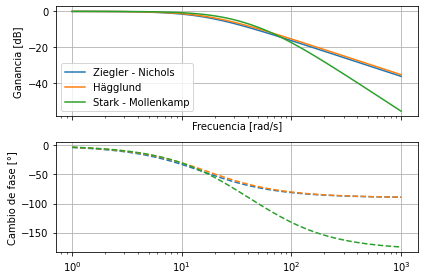

In [16]:
from scipy import signal
def expr_to_sys(expr, var, freq_space = False):
    s = var if freq_space else Dummy('s')
    tf = expr if freq_space else laplace_transform(expr, var, s, noconds=True)
    n, d = ratpoly_coeffs(tf*s, s)
    return signal.TransferFunction([*map(float, n)], [*map(float, d)])

def add_bode(sys, ax_mag, ax_phase, label=None, w=None):
    w, mag, phase = signal.bode(sys) if w is None else \
        signal.bode(sys, w)
    ax_mag.semilogx(w, mag, label=label)
    ax_phase.semilogx(w, phase, "--", label=label)

fig, (ax_mag, ax_phase) = plt.subplots(2, sharex=True)
ax_mag.set_xlabel("Frecuencia [rad/s]")
ax_mag.set_ylabel("Ganancia [dB]")
ax_phase.set_ylabel("Cambio de fase [°]")
ax_mag.grid()
ax_phase.grid()

w = np.logspace(0, 3, 100)
add_bode(expr_to_sys(respuesta_zn(t, exp), t),
    ax_mag, ax_phase, label="Ziegler - Nichols", w=w)
add_bode(expr_to_sys(respuesta_hg(t, exp), t),
    ax_mag, ax_phase, label="Hägglund", w=w)
add_bode(expr_to_sys(respuesta_sm(t, exp), t),
    ax_mag, ax_phase, label="Stark - Mollenkamp", w=w)
ax_mag.legend()
fig.tight_layout()
fig.savefig("./tp1/respuesta_en_freq.svg")

In [7]:
from utils.math import f2zpk
from sympy import roots as sroots, denom, numer, pi
[*sroots(denom(laplace_transform(respuesta_sm(t, exp), t, s, noconds=True)*s))]

[-66.2940233640473, -25.0836040101086]

## Punto 3

0.7323941167154935

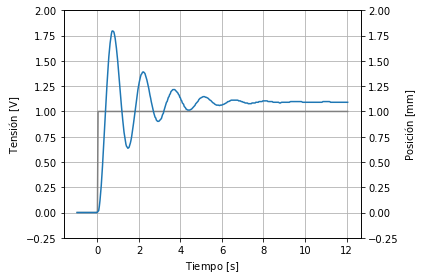

In [85]:
def normalizado(t, e, r):
    e_offset = e[0]
    r_offset = r[0]
    static_gain = r_offset / e_offset
    e_amplitude = e[-1] - e_offset
    # derivada máxima -> activación
    activation_n = np.argmax(abs(np.diff(e)))
    return static_gain, (
        t - t[activation_n],
        (e - e_offset)/e_amplitude,
        (r - r_offset)/e_amplitude)

g0, (tiempo, entrada, respuesta) = normalizado(*columnas(
    np.loadtxt("./tp1/punto3_datos.csv", delimiter=",")))

def to_outer_bound(ax1, ax2):
    (y1_min, y1_max) = ax1.get_ylim()
    (y2_min, y2_max) = ax2.get_ylim()
    bound = min(y1_min, y2_min), max(y1_max, y2_max)
    ax1.set_ylim(bound)
    ax2.set_ylim(bound)
    new_ticks = np.array([*set().union(ax1.get_yticks(), ax2.get_yticks())])
    ax1.set_yticks(new_ticks)
    ax2.set_yticks(new_ticks)

fig, ax_e = plt.subplots()
ax_r = ax_e.twinx()
ax_r.set_ylabel("Posición [$\\mathrm{mm}$]")
ax_e.set_xlabel("Tiempo [$\\mathrm{s}$]")
ax_e.set_ylabel("Tensión [$\\mathrm{V}$]")
ax_r.plot(tiempo, respuesta, label="Respuesta original")
ax_e.plot(tiempo, entrada, label="Posición del actuador", c="grey")
to_outer_bound(ax_e, ax_r)
ax_e.grid()
fig.tight_layout()
g0
n_pico = np.argmax(respuesta)
n_min = np.argmin(respuesta[n_pico:]) + n_pico
tiempo[n_min] - tiempo[n_pico]

## Punto 1

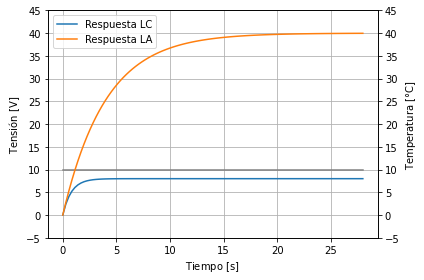

In [80]:
k1 = 100
k2 = 1
kq = 1
ks = 1
kc = 1
r = 100
l = .0001
c = 0.25

g_s = kc/(s+c)
la_s = k1*ks*kq*kc/((r+l*s)*(s+c))
lc_s = la_s/(1+la_s*k2)

def scaled_step(prop, sys, *args, **kwargs):
    t, r = sys.step(*args, **kwargs)
    return t, r*prop

vin = 10
t, r_la = scaled_step(vin, expr_to_sys(la_s, s, freq_space=True))
_, r_lc = scaled_step(vin, expr_to_sys(lc_s, s, freq_space=True), T=t)
fig, ax_e = plt.subplots()
ax_r = ax_e.twinx()
ax_r.set_ylabel("Temperatura [$\\mathrm{°C}$]")
ax_e.set_xlabel("Tiempo [$\\mathrm{s}$]")
ax_e.set_ylabel("Tensión [$\\mathrm{V}$]")
ax_r.plot(t, r_lc, label="Respuesta LC")
ax_r.plot(t, r_la, label="Respuesta LA")
ax_e.plot(t, np.ones(len(t))*vin, label="Entrada", c="grey")
ax_r.legend()
ax_e.grid()
to_outer_bound(ax_e, ax_r)
fig.tight_layout()
fig.savefig("./tp1/punto1_respuesta_temporal.svg")


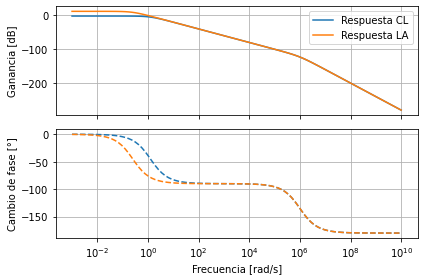

In [87]:
fig, (ax_mag, ax_phase) = plt.subplots(2, sharex=True)
ax_phase.set_xlabel("Frecuencia [rad/s]")
ax_mag.set_ylabel("Ganancia [dB]")
ax_phase.set_ylabel("Cambio de fase [°]")
ax_mag.grid()
ax_phase.grid()

w = np.logspace(-3, 10, 100)
add_bode(expr_to_sys(lc_s, s, freq_space=True),
    ax_mag, ax_phase, label="Respuesta CL", w=w)
add_bode(expr_to_sys(la_s, s, freq_space=True),
    ax_mag, ax_phase, label="Respuesta LA", w=w)
ax_mag.legend()
fig.tight_layout()
fig.savefig("./tp1/punto1_respuesta_en_freq.svg")